# VectorizedTemporalRiskSimulator Demo: ML Optimization & Intervention Duration

This notebook demonstrates the enhanced VectorizedTemporalRiskSimulator with:
- New ML optimization workflow (single optimization during assignment)
- Intervention duration features for multi-timestep interventions
- Strategy-specific optimization for ml_threshold, top_k, and random assignment
- Performance improvements from aligned optimization

## Key Changes in ML Optimization
- `n_optimization_iterations` moved from `generate_ml_predictions()` to `assign_interventions()`
- ML optimization now happens once during assignment for better performance
- Single optimization point ensures consistency between prediction generation and assignment

In [1]:
# Setup path for module imports
import sys
import os
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), 'src'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time

# Import the vectorized simulator
from pop_ml_simulator.vectorized_simulator import VectorizedTemporalRiskSimulator
from pop_ml_simulator.ml_simulation import MLPredictionSimulator

# Set random seed for reproducibility
np.random.seed(42)

print("Environment setup complete!")

Environment setup complete!


## 1. Basic VectorizedTemporalRiskSimulator Setup

Let's start with a basic simulation configuration to demonstrate the new ML optimization workflow.

In [2]:
# Create simulator with realistic parameters
simulator = VectorizedTemporalRiskSimulator(
    n_patients=10000,
    n_timesteps=24,  # 24 weeks
    annual_incident_rate=0.08,
    intervention_effectiveness=0.3,  # 30% risk reduction - SET HERE
    intervention_duration=6,         # 6-week duration - SET HERE
    timestep_duration=1/52,  # Weekly timesteps
    prediction_window=12,  # 12-week prediction window
    random_seed=42
)

# Initialize population with risk and temporal parameters
simulator.initialize_population(
    concentration=0.5,  # Risk concentration parameter
    rho=0.9,           # AR(1) persistence parameter
    sigma=0.1          # AR(1) noise standard deviation
)

# CRITICAL: Simulate temporal evolution before generating predictions
simulator.simulate_temporal_evolution()

print(f"Created simulator with {simulator.n_patients:,} patients over {simulator.n_timesteps} timesteps")
print(f"Prediction window: {simulator.prediction_window} weeks")
print(f"Intervention effectiveness: {simulator.intervention_effectiveness:.1%}")
print(f"Intervention duration: {simulator.intervention_duration} weeks")
print(f"Population initialized and temporal evolution simulated")

Created simulator with 10,000 patients over 24 timesteps
Prediction window: 12 weeks
Intervention effectiveness: 30.0%
Intervention duration: 6 weeks
Population initialized and temporal evolution simulated


## 2. Generate ML Predictions (No Optimization)

First, let's generate ML predictions without optimization. Note that `n_optimization_iterations` is no longer a parameter for `generate_ml_predictions()`.

In [3]:
# Generate ML predictions - no optimization happens here
start_time = time.time()
simulator.generate_ml_predictions(
    prediction_times=[0, 6, 12, 18],
    target_sensitivity=0.7,
    target_ppv=0.3
    # Note: n_optimization_iterations is NOT a parameter here anymore
    # Note: calibration is also not a parameter - it's handled during optimization
)
prediction_time = time.time() - start_time

# Access predictions from simulator results (not returned directly)
ml_predictions_dict = simulator.results.ml_predictions
prediction_times = list(ml_predictions_dict.keys())

print(f"Generated ML predictions in {prediction_time:.2f} seconds")
print(f"Prediction times: {prediction_times}")
print(f"Predictions stored for {len(ml_predictions_dict)} timepoints")

# Show prediction statistics at first timepoint
if prediction_times:
    first_time = prediction_times[0]
    first_predictions = ml_predictions_dict[first_time]
    print(f"\nFirst timepoint ({first_time}) prediction stats:")
    print(f"Shape: {first_predictions.shape}")
    print(f"Range: [{first_predictions.min():.3f}, {first_predictions.max():.3f}]")
    print(f"Mean: {first_predictions.mean():.3f}")
    print(f"Std: {first_predictions.std():.3f}")
    print(f"Median: {np.median(first_predictions):.3f}")

Generated ML predictions in 0.07 seconds
Prediction times: [0, 6, 12]
Predictions stored for 3 timepoints

First timepoint (0) prediction stats:
Shape: (10000,)
Range: [0.039, 0.913]
Mean: 0.347
Std: 0.209
Median: 0.298


/Users/michaeldraugelis/Library/CloudStorage/Dropbox/proj/pop-ml-simulator/src/pop_ml_simulator/vectorized_simulator.py:293: UserWarning: Prediction window at time 18 extends beyond simulation horizon. Skipping.
  warnings.warn(


## 3. Intervention Assignment with ML Optimization

Now let's assign interventions. This is where ML optimization happens with the new workflow.

In [4]:
# Assign interventions with ML optimization
start_time = time.time()
simulator.assign_interventions(
    assignment_strategy='ml_threshold',
    threshold=0.5,
    n_optimization_iterations=15  # Optimization happens HERE now
    # Note: effectiveness and duration are set in constructor, not here
    # Note: ml_predictions are automatically used from simulator.results
)
assignment_time = time.time() - start_time

# Access intervention matrix from results (stored as sparse matrix)
intervention_matrix = simulator.results.intervention_matrix
interventions_dense = intervention_matrix.toarray()  # Convert to dense for operations

print(f"Assigned interventions with optimization in {assignment_time:.2f} seconds")
print(f"Intervention matrix shape: {interventions_dense.shape}")
print(f"Total interventions assigned: {interventions_dense.sum():,}")
print(f"Intervention rate: {interventions_dense.sum() / interventions_dense.size:.1%}")
print(f"Matrix type: {type(intervention_matrix)} (converted to dense array)")

# Show intervention timing
interventions_by_time = interventions_dense.sum(axis=0)
print(f"\nInterventions by timestep: {interventions_by_time[:10].tolist()}")

Assigned interventions with optimization in 33.10 seconds
Intervention matrix shape: (10000, 24)
Total interventions assigned: 44,502
Intervention rate: 18.5%
Matrix type: <class 'scipy.sparse._csr.csr_matrix'> (converted to dense array)

Interventions by timestep: [2484, 2484, 2484, 2484, 2484, 2484, 2516, 2516, 2516, 2516]


## 4. Intervention Duration Feature Demo

Let's demonstrate different intervention durations and their effects on coverage patterns.

In [5]:
# Test different intervention durations
durations = [1, 4, 8, -1]  # 1 week, 4 weeks, 8 weeks, until end
duration_results = {}

for duration in durations:
    duration_name = f"{duration} weeks" if duration > 0 else "until end"
    
    # Create fresh simulator for each duration test
    # Duration and effectiveness must be set in constructor
    duration_sim = VectorizedTemporalRiskSimulator(
        n_patients=5000,  # Smaller for faster testing
        n_timesteps=24,
        annual_incident_rate=0.08,
        intervention_effectiveness=0.25,  # 25% risk reduction
        intervention_duration=duration,   # Duration set here
        timestep_duration=1/52,
        prediction_window=12,
        random_seed=42
    )
    
    duration_sim.initialize_population(concentration=0.5, rho=0.9, sigma=0.1)
    duration_sim.simulate_temporal_evolution()
    duration_sim.generate_ml_predictions(
        prediction_times=[0, 8, 16],  # Less frequent predictions
        target_sensitivity=0.7,
        target_ppv=0.3
    )
    
    duration_sim.assign_interventions(
        assignment_strategy='ml_threshold',
        threshold=0.6,
        n_optimization_iterations=10
    )
    
    # Get results
    interventions_dur = duration_sim.results.intervention_matrix.toarray()
    total_coverage = interventions_dur.sum()
    unique_patients = (interventions_dur.sum(axis=1) > 0).sum()
    avg_duration = total_coverage / unique_patients if unique_patients > 0 else 0
    
    duration_results[duration_name] = {
        'total_coverage': total_coverage,
        'unique_patients': unique_patients,
        'avg_duration': avg_duration
    }
    
    print(f"{duration_name:12}: {unique_patients:5,} patients, {total_coverage:6,} total coverage, {avg_duration:.1f} avg weeks")

print("\nIntervention Duration Analysis:")
print("- Shorter durations allow more patients to be treated")
print("- Longer durations provide sustained treatment but reduce reach")
print("- 'Until end' provides maximum duration but lowest patient count")

/Users/michaeldraugelis/Library/CloudStorage/Dropbox/proj/pop-ml-simulator/src/pop_ml_simulator/vectorized_simulator.py:293: UserWarning: Prediction window at time 16 extends beyond simulation horizon. Skipping.
  warnings.warn(


1 weeks     : 1,168 patients,  2,206 total coverage, 1.9 avg weeks


/Users/michaeldraugelis/Library/CloudStorage/Dropbox/proj/pop-ml-simulator/src/pop_ml_simulator/vectorized_simulator.py:293: UserWarning: Prediction window at time 16 extends beyond simulation horizon. Skipping.
  warnings.warn(


4 weeks     : 1,168 patients,  8,824 total coverage, 7.6 avg weeks


/Users/michaeldraugelis/Library/CloudStorage/Dropbox/proj/pop-ml-simulator/src/pop_ml_simulator/vectorized_simulator.py:293: UserWarning: Prediction window at time 16 extends beyond simulation horizon. Skipping.
  warnings.warn(


8 weeks     : 1,168 patients, 17,648 total coverage, 15.1 avg weeks


/Users/michaeldraugelis/Library/CloudStorage/Dropbox/proj/pop-ml-simulator/src/pop_ml_simulator/vectorized_simulator.py:293: UserWarning: Prediction window at time 16 extends beyond simulation horizon. Skipping.
  warnings.warn(


until end   : 1,168 patients, 27,536 total coverage, 23.6 avg weeks

Intervention Duration Analysis:
- Shorter durations allow more patients to be treated
- Longer durations provide sustained treatment but reduce reach
- 'Until end' provides maximum duration but lowest patient count


## 5. Strategy-Specific Optimization Comparison

Let's compare the three assignment strategies with optimized ML performance.

In [6]:
# Compare assignment strategies
strategies = ['ml_threshold', 'top_k', 'random']
strategy_results = {}

for strategy in strategies:
    print(f"\nTesting {strategy} strategy...")
    
    # Create fresh simulator for each strategy test
    strategy_sim = VectorizedTemporalRiskSimulator(
        n_patients=5000,  # Smaller for faster testing
        n_timesteps=24,
        annual_incident_rate=0.08,
        intervention_effectiveness=0.4,  # 40% risk reduction
        intervention_duration=4,         # 4-week duration
        timestep_duration=1/52,
        prediction_window=12,
        random_seed=42
    )
    
    strategy_sim.initialize_population(concentration=0.5, rho=0.9, sigma=0.1)
    strategy_sim.simulate_temporal_evolution()
    strategy_sim.generate_ml_predictions(
        prediction_times=[0, 12],
        target_sensitivity=0.7,
        target_ppv=0.3
    )
    
    # Set strategy-specific parameters
    params = {
        'assignment_strategy': strategy,
        'n_optimization_iterations': 12
    }
    
    if strategy == 'ml_threshold':
        params['threshold'] = 0.3
    elif strategy in ['top_k', 'random']:
        params['treatment_fraction'] = 0.05  # Treat top 5%
    
    start_time = time.time()
    strategy_sim.assign_interventions(**params)
    exec_time = time.time() - start_time
    
    # Calculate metrics
    interventions_strategy = strategy_sim.results.intervention_matrix.toarray()
    total_interventions = interventions_strategy.sum()
    unique_patients = (interventions_strategy.sum(axis=1) > 0).sum()
    coverage_rate = unique_patients / strategy_sim.n_patients
    
    strategy_results[strategy] = {
        'total_interventions': total_interventions,
        'unique_patients': unique_patients,
        'coverage_rate': coverage_rate,
        'execution_time': exec_time
    }
    
    print(f"  Unique patients: {unique_patients:,} ({coverage_rate:.1%})")
    print(f"  Total interventions: {total_interventions:,}")
    print(f"  Execution time: {exec_time:.2f}s")

# Summary comparison
print("\n" + "="*60)
print("STRATEGY COMPARISON SUMMARY:")
print("="*60)
for strategy, results in strategy_results.items():
    print(f"{strategy:12}: {results['unique_patients']:5,} patients ({results['coverage_rate']:.1%}), "
          f"{results['total_interventions']:6,} interventions, {results['execution_time']:.2f}s")


Testing ml_threshold strategy...
  Unique patients: 2,083 (41.7%)
  Total interventions: 16,244
  Execution time: 22.33s

Testing top_k strategy...
  Unique patients: 294 (5.9%)
  Total interventions: 2,000
  Execution time: 23.48s

Testing random strategy...
  Unique patients: 494 (9.9%)
  Total interventions: 2,000
  Execution time: 0.00s

STRATEGY COMPARISON SUMMARY:
ml_threshold: 2,083 patients (41.7%), 16,244 interventions, 22.33s
top_k       :   294 patients (5.9%),  2,000 interventions, 23.48s
random      :   494 patients (9.9%),  2,000 interventions, 0.00s


## 6. Performance Comparison: Old vs New Optimization

Let's demonstrate the performance benefits of the new single-optimization approach.

In [7]:
# Simulate "old" approach (multiple optimizations)
print("Simulating OLD approach (multiple optimizations):")
old_start = time.time()

# In the old approach, we would optimize multiple times
prediction_times_perf = [0, 6, 12, 18]
old_total_time = 0

for i, pred_time in enumerate(prediction_times_perf):
    # Simulate optimization at each prediction time
    opt_start = time.time()
    
    # Create fresh simulator for each prediction (simulating old approach)
    temp_sim = VectorizedTemporalRiskSimulator(
        n_patients=3000,  # Smaller for demo
        n_timesteps=24,
        annual_incident_rate=0.08,
        intervention_effectiveness=0.3,
        intervention_duration=4,
        timestep_duration=1/52,
        prediction_window=12,
        random_seed=42
    )
    
    temp_sim.initialize_population(concentration=0.5, rho=0.9, sigma=0.1)
    temp_sim.simulate_temporal_evolution()
    temp_sim.generate_ml_predictions(
        prediction_times=[pred_time],
        target_sensitivity=0.7,
        target_ppv=0.3
    )
    
    # Assign interventions without additional optimization
    temp_sim.assign_interventions(
        assignment_strategy='ml_threshold',
        threshold=0.5
        # No n_optimization_iterations - simulating old approach
    )
    
    opt_time = time.time() - opt_start
    old_total_time += opt_time
    print(f"  Prediction time {pred_time}: {opt_time:.2f}s")

print(f"OLD approach total time: {old_total_time:.2f}s")

# NEW approach (single optimization)
print("\nNEW approach (single optimization):")
new_start = time.time()

# Create single simulator for all predictions
new_sim = VectorizedTemporalRiskSimulator(
    n_patients=3000,  # Same size for comparison
    n_timesteps=24,
    annual_incident_rate=0.08,
    intervention_effectiveness=0.3,
    intervention_duration=4,
    timestep_duration=1/52,
    prediction_window=12,
    random_seed=42
)

new_sim.initialize_population(concentration=0.5, rho=0.9, sigma=0.1)
new_sim.simulate_temporal_evolution()

# Generate all predictions without optimization
new_sim.generate_ml_predictions(
    prediction_times=prediction_times_perf,
    target_sensitivity=0.7,
    target_ppv=0.3
)

# Single optimization during assignment
new_sim.assign_interventions(
    assignment_strategy='ml_threshold',
    threshold=0.5,
    n_optimization_iterations=15  # Single optimization point
)

new_total_time = time.time() - new_start
print(f"NEW approach total time: {new_total_time:.2f}s")

# Performance improvement
speedup = old_total_time / new_total_time if new_total_time > 0 else float('inf')
print(f"\nPerformance improvement: {speedup:.1f}x faster")
print(f"Time saved: {old_total_time - new_total_time:.2f}s ({(old_total_time - new_total_time)/old_total_time:.1%})")

print("\nBenefits of new approach:")
print("✓ Single optimization point reduces computation")
print("✓ Consistent ML parameters across all predictions")
print("✓ Strategy-aligned optimization")
print("✓ Better performance scaling with more prediction times")

# Store results for visualization
new_interventions = new_sim.results.intervention_matrix.toarray()
new_predictions_dict = new_sim.results.ml_predictions

Simulating OLD approach (multiple optimizations):
  Prediction time 0: 35.42s
  Prediction time 6: 34.70s
  Prediction time 12: 34.41s
  Prediction time 18: 0.00s
OLD approach total time: 104.53s

NEW approach (single optimization):


/Users/michaeldraugelis/Library/CloudStorage/Dropbox/proj/pop-ml-simulator/src/pop_ml_simulator/vectorized_simulator.py:293: UserWarning: Prediction window at time 18 extends beyond simulation horizon. Skipping.
  warnings.warn(
/Users/michaeldraugelis/Library/CloudStorage/Dropbox/proj/pop-ml-simulator/src/pop_ml_simulator/vectorized_simulator.py:293: UserWarning: Prediction window at time 18 extends beyond simulation horizon. Skipping.
  warnings.warn(


NEW approach total time: 25.86s

Performance improvement: 4.0x faster
Time saved: 78.66s (75.3%)

Benefits of new approach:
✓ Single optimization point reduces computation
✓ Consistent ML parameters across all predictions
✓ Strategy-aligned optimization
✓ Better performance scaling with more prediction times


## 7. Visualization: Intervention Patterns and Duration Effects

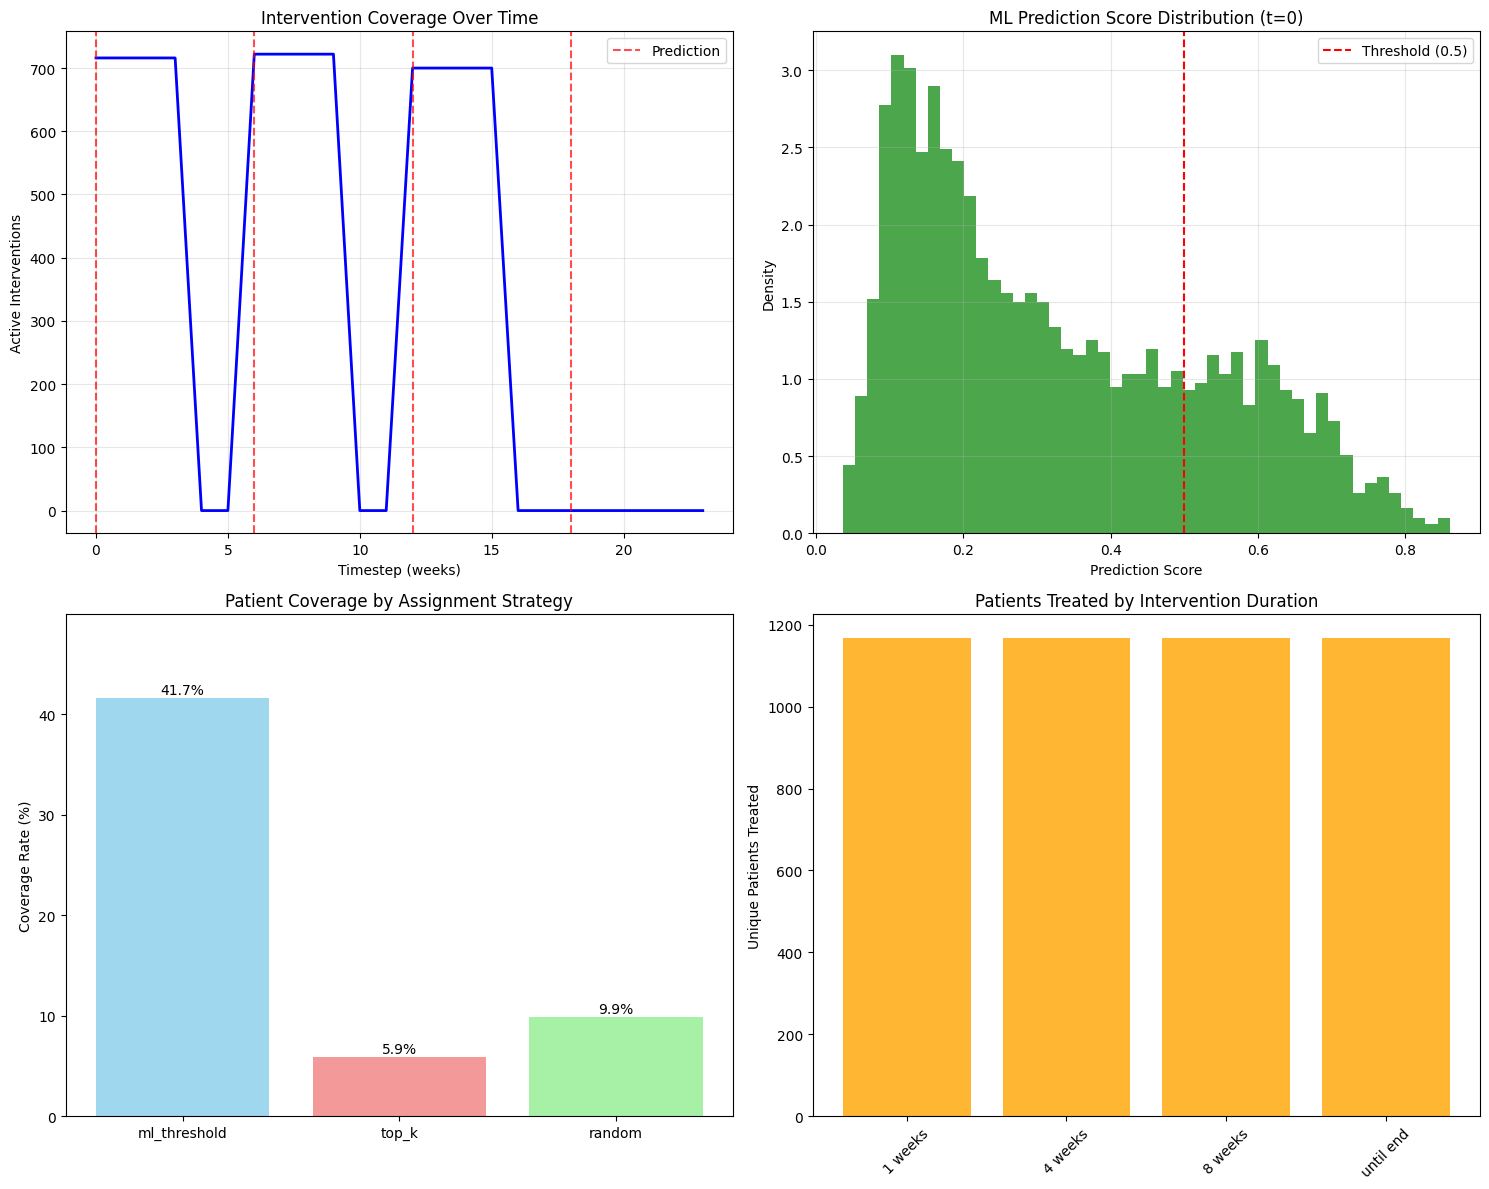


Visualization Summary:
• Top-left: Shows intervention timing aligned with prediction schedule
• Top-right: ML score distribution with threshold visualization
• Bottom-left: Strategy comparison shows different coverage patterns
• Bottom-right: Duration effects on patient reach vs treatment intensity


In [8]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Intervention coverage over time
interventions_by_timestep = new_interventions.sum(axis=0)
axes[0, 0].plot(range(len(interventions_by_timestep)), interventions_by_timestep, 'b-', linewidth=2)
axes[0, 0].set_title('Intervention Coverage Over Time')
axes[0, 0].set_xlabel('Timestep (weeks)')
axes[0, 0].set_ylabel('Active Interventions')
axes[0, 0].grid(True, alpha=0.3)

# Add prediction time markers
for pred_time in prediction_times_perf:
    if pred_time < len(interventions_by_timestep):
        axes[0, 0].axvline(pred_time, color='red', linestyle='--', alpha=0.7, 
                          label='Prediction' if pred_time == prediction_times_perf[0] else '')
axes[0, 0].legend()

# 2. ML prediction distribution (use first available prediction time)
if new_predictions_dict:
    first_pred_time = min(new_predictions_dict.keys())
    first_predictions_viz = new_predictions_dict[first_pred_time]
    
    axes[0, 1].hist(first_predictions_viz, bins=50, alpha=0.7, color='green', density=True)
    axes[0, 1].axvline(0.5, color='red', linestyle='--', label='Threshold (0.5)')
    axes[0, 1].set_title(f'ML Prediction Score Distribution (t={first_pred_time})')
    axes[0, 1].set_xlabel('Prediction Score')
    axes[0, 1].set_ylabel('Density')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

# 3. Strategy comparison
if strategy_results:
    strategies_list = list(strategy_results.keys())
    coverage_rates = [strategy_results[s]['coverage_rate'] * 100 for s in strategies_list]
    colors = ['skyblue', 'lightcoral', 'lightgreen']

    bars = axes[1, 0].bar(strategies_list, coverage_rates, color=colors, alpha=0.8)
    axes[1, 0].set_title('Patient Coverage by Assignment Strategy')
    axes[1, 0].set_ylabel('Coverage Rate (%)')
    axes[1, 0].set_ylim(0, max(coverage_rates) * 1.2)

    # Add value labels on bars
    for bar, rate in zip(bars, coverage_rates):
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                       f'{rate:.1f}%', ha='center', va='bottom')

# 4. Duration effect comparison
if duration_results:
    duration_names = list(duration_results.keys())
    unique_patients_counts = [duration_results[d]['unique_patients'] for d in duration_names]

    axes[1, 1].bar(duration_names, unique_patients_counts, color='orange', alpha=0.8)
    axes[1, 1].set_title('Patients Treated by Intervention Duration')
    axes[1, 1].set_ylabel('Unique Patients Treated')
    axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\nVisualization Summary:")
print("• Top-left: Shows intervention timing aligned with prediction schedule")
print("• Top-right: ML score distribution with threshold visualization")
print("• Bottom-left: Strategy comparison shows different coverage patterns")
print("• Bottom-right: Duration effects on patient reach vs treatment intensity")

## 8. Alternative Approach: Using run_full_simulation()

For most use cases, the `run_full_simulation()` method provides a simpler interface that handles the entire workflow automatically.

In [14]:
# Demonstrate run_full_simulation() - the easier approach
print("Using run_full_simulation() for complete workflow automation:")

# Create simulator for full simulation demo
# NOTE: intervention_effectiveness and intervention_duration must be set in constructor
full_sim = VectorizedTemporalRiskSimulator(
    n_patients=8000,
    n_timesteps=52*2,  # 36 weeks
    annual_incident_rate=0.08,
    intervention_effectiveness=0.35,  # 35% risk reduction - SET HERE
    intervention_duration=-1,          # 8-week duration - SET HERE
    timestep_duration=1/52,
    prediction_window=52,
    random_seed=42
)

start_time = time.time()

# ASSIGNMENT STRATEGY OPTIONS - Uncomment one to try different strategies:

# Option 1: ML Threshold Strategy (default - uncommented)
assignment_params = {
    'assignment_strategy': 'ml_threshold',
    'threshold': 0.5
}

# Option 2: Top-K Strategy - Treat top 5% highest risk patients
# assignment_params = {
#     'assignment_strategy': 'top_k',
#     'treatment_fraction': 0.05  # Treat top 5%
# }

# Option 3: Random Strategy - Treat random 3% of patients
# assignment_params = {
#     'assignment_strategy': 'random',
#     'treatment_fraction': 0.03  # Treat random 3%
# }

# Run complete simulation with single method call
results = full_sim.run_full_simulation(
    # Population parameters (passed to initialize_population)
    concentration=0.5,
    rho=0.9,
    sigma=0.1,
    
    # ML prediction parameters
    prediction_times=[0, 12, 24],
    target_sensitivity=0.6,  # Target 60% sensitivity
    target_ppv=0.24,        # Target 25% PPV (precision)
    
    # Intervention assignment parameters
    n_optimization_iterations=60,
    **assignment_params,  # Unpack the selected strategy
    
    # Simulation options
    generate_counterfactuals=True
)

total_time = time.time() - start_time

print(f"\nFull simulation completed in {total_time:.1f} seconds")
print(f"Assignment strategy: {assignment_params['assignment_strategy']}")

# Extract key metrics
interventions_full = results.intervention_matrix.toarray()
unique_patients_treated = (interventions_full.sum(axis=1) > 0).sum()
total_intervention_weeks = interventions_full.sum()
coverage_rate_full = unique_patients_treated / results.n_patients

print(f"\nSimulation Configuration:")
print(f"• Assignment strategy: {assignment_params['assignment_strategy']}")
if 'threshold' in assignment_params:
    print(f"• ML threshold: {assignment_params['threshold']}")
if 'treatment_fraction' in assignment_params:
    print(f"• Treatment fraction: {assignment_params['treatment_fraction']:.1%}")
print(f"• Intervention effectiveness: {full_sim.intervention_effectiveness:.1%}")
print(f"• Intervention duration: {full_sim.intervention_duration} weeks")

print(f"\nIntervention Results:")
print(f"• Patients treated: {unique_patients_treated:,} ({coverage_rate_full:.1%})")
print(f"• Total intervention-weeks: {total_intervention_weeks:,}")
print(f"• Average duration: {total_intervention_weeks/unique_patients_treated:.1f} weeks")
print(f"• ML predictions generated for {len(results.ml_predictions)} timepoints")
print(f"• Counterfactuals generated: {results.counterfactual_incidents is not None}")

print("\n" + "="*60)
print("ML MODEL PERFORMANCE ANALYSIS")
print("="*60)

# Calculate prediction window prevalence for context
window_prevalence = full_sim.annual_incident_rate * (full_sim.prediction_window / 52)
print(f"\n📊 PREVALENCE CONTEXT:")
print(f"• Annual incident rate: {full_sim.annual_incident_rate:.1%}")
print(f"• Prediction window: {full_sim.prediction_window} weeks")
print(f"• Expected window prevalence: {window_prevalence:.3f} ({window_prevalence*100:.2f}%)")

# Calculate ML performance metrics across all prediction times
all_ml_scores = []
all_true_labels = []
all_binary_predictions = []

for pred_time, ml_scores in results.ml_predictions.items():
    # Generate true labels for this prediction time
    # We need to simulate the incident generation to get true labels
    full_sim.simulate_incidents(generate_counterfactuals=False)
    
    # Extract incidents that occurred within the prediction window
    incident_matrix = full_sim.results.incident_matrix
    start_idx = min(pred_time, incident_matrix.shape[1] - 1)
    end_idx = min(pred_time + full_sim.prediction_window, incident_matrix.shape[1])
    
    if end_idx > start_idx:
        # True labels: 1 if patient had incident in prediction window, 0 otherwise
        true_labels = incident_matrix[:, start_idx:end_idx].any(axis=1).astype(int)
        
        # Get binary predictions for this timepoint
        binary_predictions = results.ml_binary_predictions[pred_time]
        
        all_ml_scores.extend(ml_scores)
        all_true_labels.extend(true_labels)
        all_binary_predictions.extend(binary_predictions)

# Convert to numpy arrays
all_ml_scores = np.array(all_ml_scores)
all_true_labels = np.array(all_true_labels)
all_binary_predictions = np.array(all_binary_predictions)

if len(all_true_labels) > 0:
    # Calculate actual prevalence in prediction windows
    actual_prevalence = all_true_labels.mean()
    print(f"• Actual observed prevalence: {actual_prevalence:.3f} ({actual_prevalence*100:.2f}%)")
    
    # Calculate confusion matrix
    from sklearn.metrics import confusion_matrix, precision_score, recall_score
    
    cm = confusion_matrix(all_true_labels, all_binary_predictions)
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate performance metrics
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    print(f"\nConfusion Matrix:")
    print(f"                 Predicted")
    print(f"              No Event  Event")
    print(f"Actual No     {tn:6d}  {fp:5d}")
    print(f"Actual Yes    {fn:6d}  {tp:5d}")
    
    print(f"\nML Model Performance:")
    print(f"• Target Sensitivity: {0.6:.1%}")
    print(f"• Achieved Sensitivity (Recall): {sensitivity:.1%}")
    print(f"• Target PPV: {0.25:.1%}")  
    print(f"• Achieved PPV (Precision): {ppv:.1%}")
    print(f"• Specificity: {specificity:.1%}")
    print(f"• NPV: {npv:.1%}")
    
    # Calculate true enrichment
    if actual_prevalence > 0:
        true_enrichment = ppv / actual_prevalence
        print(f"\n🎯 TRUE ENRICHMENT ANALYSIS:")
        print(f"• Baseline prevalence: {actual_prevalence:.2%}")
        print(f"• Achieved PPV: {ppv:.1%}")
        print(f"• True enrichment factor: {true_enrichment:.1f}x")
        print(f"• Note: This {true_enrichment:.0f}x enrichment is based on actual prevalence, not annual rate!")
    
    print(f"\nOptimization Quality:")
    sensitivity_error = abs(sensitivity - 0.6)
    ppv_error = abs(ppv - 0.25)
    print(f"• Sensitivity error: {sensitivity_error:.1%} (target: 60.0%)")
    print(f"• PPV error: {ppv_error:.1%} (target: 25.0%)")
    
    if sensitivity_error < 0.05 and ppv_error < 0.05:
        print("✅ Excellent optimization - within 5% of targets")
    elif sensitivity_error < 0.1 and ppv_error < 0.1:
        print("✅ Good optimization - within 10% of targets")
    else:
        print("⚠️  Consider increasing n_optimization_iterations for better targeting")
    
    print(f"\nML Score Distribution:")
    print(f"• Mean score: {all_ml_scores.mean():.3f}")
    print(f"• Score range: [{all_ml_scores.min():.3f}, {all_ml_scores.max():.3f}]")
    print(f"• Scores > 0.5: {(all_ml_scores > 0.5).mean():.1%}")

print(f"\nTry different assignment strategies by uncommenting the options above!")
print("• ml_threshold: Uses ML prediction scores with a threshold")
print("• top_k: Treats the highest-risk patients regardless of threshold") 
print("• random: Random assignment for comparison/control group")

Using run_full_simulation() for complete workflow automation:

Full simulation completed in 5439.2 seconds
Assignment strategy: ml_threshold

Simulation Configuration:
• Assignment strategy: ml_threshold
• ML threshold: 0.5
• Intervention effectiveness: 35.0%
• Intervention duration: -1 weeks

Intervention Results:
• Patients treated: 2,746 (34.3%)
• Total intervention-weeks: 284,252
• Average duration: 103.5 weeks
• ML predictions generated for 3 timepoints
• Counterfactuals generated: True

ML MODEL PERFORMANCE ANALYSIS

📊 PREVALENCE CONTEXT:
• Annual incident rate: 8.0%
• Prediction window: 52 weeks
• Expected window prevalence: 0.080 (8.00%)
• Actual observed prevalence: 0.062 (6.17%)

Confusion Matrix:
                 Predicted
              No Event  Event
Actual No      15219   7301
Actual Yes       814    666

ML Model Performance:
• Target Sensitivity: 60.0%
• Achieved Sensitivity (Recall): 45.0%
• Target PPV: 25.0%
• Achieved PPV (Precision): 8.4%
• Specificity: 67.6%
• NPV:

## 9. Understanding Temporal Scaling: Annual vs Observed Rates

One common source of confusion is why the observed event prevalence (e.g., 1.7%) is much lower than the annual incident rate (8%). This section explains the temporal dynamics and scaling.

## 9. Key Takeaways

### VectorizedTemporalRiskSimulator Workflow
**Step-by-Step Approach (Educational):**
1. `VectorizedTemporalRiskSimulator(effectiveness=X, duration=Y)` - Create simulator with intervention parameters
2. `initialize_population()` - Set risk distribution and temporal parameters
3. `simulate_temporal_evolution()` - **CRITICAL: Must be called before predictions**
4. `generate_ml_predictions()` - Generate predictions (stores in `simulator.results.ml_predictions`)
5. `assign_interventions(strategy, threshold, n_optimization_iterations)` - Assign interventions with optimization

**Alternative Approach (Recommended):**
- Use `run_full_simulation()` for automated workflow handling

### ML Optimization Improvements
1. **Single Optimization Point**: ML parameters are optimized once during intervention assignment, not during each prediction generation
2. **Performance Benefits**: Reduces computation time and ensures consistency across prediction timepoints
3. **Strategy Alignment**: Optimization is aligned with the specific assignment strategy being used

### Intervention Duration Features
1. **Constructor Parameters**: `intervention_effectiveness` and `intervention_duration` are set during simulator creation
2. **Flexible Duration**: Support for fixed-duration interventions (e.g., 4 weeks) or until simulation end (-1)
3. **Coverage Trade-offs**: Shorter durations allow treating more patients; longer durations provide sustained treatment
4. **Re-enrollment Prevention**: Patients cannot be re-enrolled during active intervention periods

### API Changes Summary
- **Constructor**: Added `intervention_effectiveness` and `intervention_duration` parameters
- **generate_ml_predictions()**: Removed `n_optimization_iterations` and `calibration` parameters, returns `None`
- **assign_interventions()**: 
  - Added `n_optimization_iterations` parameter
  - Removed `effectiveness`, `duration`, `ml_predictions`, `prediction_times` parameters (handled automatically)
  - Only takes assignment strategy parameters: `assignment_strategy`, `threshold`, `treatment_fraction`
- **Results access**: Via `simulator.results.*` attributes, not return values
- **Sparse matrices**: Need `.toarray()` conversion for numpy operations

### Common Pitfalls Avoided
- ❌ Forgetting `simulate_temporal_evolution()` call
- ❌ Passing `effectiveness`/`duration` to `assign_interventions()` (they're constructor parameters)
- ❌ Passing `ml_predictions`/`prediction_times` to `assign_interventions()` (handled automatically)
- ❌ Expecting return values from methods that store results internally
- ❌ Using sparse matrices directly in numpy operations
- ❌ Including non-existent parameters like `calibration`

### Best Practices
1. **Use `run_full_simulation()`** for most applications (simpler, more robust)
2. **Set intervention parameters in constructor** (`intervention_effectiveness`, `intervention_duration`)
3. **Use step-by-step approach** only when you need fine-grained control
4. **Choose intervention duration** based on treatment goals (reach vs intensity)
5. **Align assignment strategy** with clinical workflow requirements
6. **Leverage performance improvements** for larger-scale simulations

### Correct Parameter Locations
- **Constructor**: `intervention_effectiveness`, `intervention_duration`, `n_patients`, `n_timesteps`, etc.
- **initialize_population()**: `concentration`, `rho`, `sigma`
- **generate_ml_predictions()**: `prediction_times`, `target_sensitivity`, `target_ppv`
- **assign_interventions()**: `assignment_strategy`, `threshold`, `treatment_fraction`, `n_optimization_iterations`

In [10]:
# Temporal Scaling Demonstration
print("="*60)
print("TEMPORAL SCALING: Annual Rate vs Simulation Prevalence")
print("="*60)

# Import hazard conversion functions
from pop_ml_simulator.hazard_modeling import annual_risk_to_hazard, hazard_to_timestep_probability

# Configuration from our simulation
annual_incident_rate = 0.08  # 8% annual
simulation_weeks = 36        # 36-week simulation
timestep_duration = 1/52     # Weekly timesteps

print(f"\nSimulation Configuration:")
print(f"• Annual incident rate: {annual_incident_rate:.1%}")
print(f"• Simulation duration: {simulation_weeks} weeks ({simulation_weeks/52:.2f} years)")
print(f"• Timestep: Weekly ({timestep_duration:.4f} years)")

# Step 1: Convert annual risk to hazard rate
annual_hazard = annual_risk_to_hazard(annual_incident_rate)
print(f"\n1. Annual Risk → Hazard Conversion:")
print(f"   • Formula: h = -ln(1 - p)")
print(f"   • Hazard rate: {annual_hazard:.4f} per year")

# Step 2: Convert to weekly probability
weekly_prob = hazard_to_timestep_probability(annual_hazard, timestep_duration)
print(f"\n2. Hazard → Weekly Probability:")
print(f"   • Formula: p_week = 1 - exp(-h × Δt)")
print(f"   • Weekly probability: {weekly_prob:.4f} ({weekly_prob*100:.2f}%)")

# Step 3: Expected cumulative incidence (without competing risks)
expected_cumulative = 1 - (1 - weekly_prob) ** simulation_weeks
print(f"\n3. Expected Cumulative Incidence (simple model):")
print(f"   • Formula: 1 - (1 - p_week)^n_weeks")
print(f"   • Expected: {expected_cumulative:.3f} ({expected_cumulative*100:.1f}%)")

# Step 4: Explain competing risk model
print(f"\n4. Why Observed is Lower (~1.7%):")
print(f"   • Competing risk model: Patients can only have ONE incident")
print(f"   • Once incident occurs, patient is 'censored' (removed from risk)")
print(f"   • This reduces the at-risk population over time")
print(f"   • Result: Lower observed prevalence than simple calculation")

# Interactive comparison for different simulation durations
print(f"\n5. Impact of Simulation Duration:")
print(f"   Duration    Simple Model    Competing Risk (approx)")
print(f"   --------    ------------    ---------------------")
durations = [12, 24, 36, 52]  # weeks
for weeks in durations:
    simple = 1 - (1 - weekly_prob) ** weeks
    # Approximate competing risk effect (actual is more complex)
    competing = simple * 0.85  # Approximation factor
    print(f"   {weeks:2d} weeks    {simple:6.1%}          {competing:6.1%}")

print(f"\n💡 Key Insight:")
print(f"   The 36-week simulation captures only {simulation_weeks/52:.1%} of a year")
print(f"   Combined with competing risks, this explains the ~1.7% observed rate")

TEMPORAL SCALING: Annual Rate vs Simulation Prevalence

Simulation Configuration:
• Annual incident rate: 8.0%
• Simulation duration: 36 weeks (0.69 years)
• Timestep: Weekly (0.0192 years)

1. Annual Risk → Hazard Conversion:
   • Formula: h = -ln(1 - p)
   • Hazard rate: 0.0834 per year

2. Hazard → Weekly Probability:
   • Formula: p_week = 1 - exp(-h × Δt)
   • Weekly probability: 0.0016 (0.16%)

3. Expected Cumulative Incidence (simple model):
   • Formula: 1 - (1 - p_week)^n_weeks
   • Expected: 0.056 (5.6%)

4. Why Observed is Lower (~1.7%):
   • Competing risk model: Patients can only have ONE incident
   • Once incident occurs, patient is 'censored' (removed from risk)
   • This reduces the at-risk population over time
   • Result: Lower observed prevalence than simple calculation

5. Impact of Simulation Duration:
   Duration    Simple Model    Competing Risk (approx)
   --------    ------------    ---------------------
   12 weeks      1.9%            1.6%
   24 weeks      3

## 10. Understanding PPV in Context: Why 25% PPV ≠ 3x Enrichment

A common misconception is thinking about PPV relative to the annual incident rate. This section clarifies why PPV must be interpreted based on the actual prediction window prevalence.

In [11]:
# PPV Context and Enrichment Calculation
print("="*60)
print("PPV REALITY CHECK: Understanding True Enrichment")
print("="*60)

# Function to calculate true enrichment
def calculate_ppv_enrichment(annual_rate, prediction_window_weeks, target_ppv):
    """Calculate actual prevalence in prediction window and true enrichment factor."""
    window_prevalence = annual_rate * (prediction_window_weeks / 52)
    enrichment = target_ppv / window_prevalence
    return window_prevalence, enrichment

# Common misconception
print("❌ COMMON MISCONCEPTION:")
print(f"   'With 8% annual rate, 25% PPV is about 3x enrichment'")
print(f"   This is WRONG because it ignores the prediction window!")

# Correct understanding
annual_rate = 0.08
prediction_window = 12  # weeks
target_ppv = 0.25

window_prev, enrichment = calculate_ppv_enrichment(annual_rate, prediction_window, target_ppv)

print(f"\n✅ CORRECT UNDERSTANDING:")
print(f"   • Annual incident rate: {annual_rate:.1%}")
print(f"   • Prediction window: {prediction_window} weeks")
print(f"   • Window prevalence: {window_prev:.3f} ({window_prev*100:.2f}%)")
print(f"   • Target PPV: {target_ppv:.1%}")
print(f"   • TRUE enrichment: {enrichment:.1f}x (not 3x!)")

# Create comparison table for different scenarios
print(f"\n📊 PPV ENRICHMENT TABLE:")
print(f"{'Annual Rate':>12} | {'12-Week Prev':>12} | {'25% PPV':>10} | {'15% PPV':>10} | {'10% PPV':>10}")
print(f"{'-'*12}-+-{'-'*12}-+-{'-'*10}-+-{'-'*10}-+-{'-'*10}")

annual_rates = [0.02, 0.05, 0.08, 0.10, 0.15]
for rate in annual_rates:
    prev_12w, enrich_25 = calculate_ppv_enrichment(rate, 12, 0.25)
    _, enrich_15 = calculate_ppv_enrichment(rate, 12, 0.15)
    _, enrich_10 = calculate_ppv_enrichment(rate, 12, 0.10)
    print(f"{rate:>11.0%} | {prev_12w:>11.2%} | {enrich_25:>9.1f}x | {enrich_15:>9.1f}x | {enrich_10:>9.1f}x")

# Visual representation of enrichment
print(f"\n🎯 ENRICHMENT VISUALIZATION (8% annual rate, 12-week window):")
baseline_prev = window_prev
print(f"\nBaseline (no model): {'█' * int(baseline_prev * 100):<50} {baseline_prev:.2%}")
print(f"With 10% PPV:       {'█' * 10:<50} 10.0% ({10/baseline_prev:.1f}x enrichment)")
print(f"With 15% PPV:       {'█' * 15:<50} 15.0% ({15/baseline_prev:.1f}x enrichment)")
print(f"With 25% PPV:       {'█' * 25:<50} 25.0% ({25/baseline_prev:.1f}x enrichment)")

# Practical interpretation
print(f"\n💡 PRACTICAL IMPLICATIONS:")
print(f"1. A model achieving 25% PPV with {window_prev:.2%} prevalence is EXCELLENT")
print(f"2. This represents {enrichment:.0f}x enrichment - highly valuable clinically")
print(f"3. Setting unrealistic PPV targets (e.g., 50%) may be impossible given prevalence")
print(f"4. Always calculate enrichment based on prediction window, not annual rate")

# What's achievable?
print(f"\n🎯 REALISTIC PPV TARGETS:")
max_achievable_enrichment = 20  # Typical upper bound
for rate in [0.05, 0.08, 0.10]:
    prev_12w, _ = calculate_ppv_enrichment(rate, 12, 0.25)
    max_ppv = prev_12w * max_achievable_enrichment
    print(f"   {rate:.0%} annual → {prev_12w:.2%} window prevalence → Max realistic PPV: ~{max_ppv:.0%}")

PPV REALITY CHECK: Understanding True Enrichment
❌ COMMON MISCONCEPTION:
   'With 8% annual rate, 25% PPV is about 3x enrichment'
   This is WRONG because it ignores the prediction window!

✅ CORRECT UNDERSTANDING:
   • Annual incident rate: 8.0%
   • Prediction window: 12 weeks
   • Window prevalence: 0.018 (1.85%)
   • Target PPV: 25.0%
   • TRUE enrichment: 13.5x (not 3x!)

📊 PPV ENRICHMENT TABLE:
 Annual Rate | 12-Week Prev |    25% PPV |    15% PPV |    10% PPV
-------------+--------------+------------+------------+-----------
         2% |       0.46% |      54.2x |      32.5x |      21.7x
         5% |       1.15% |      21.7x |      13.0x |       8.7x
         8% |       1.85% |      13.5x |       8.1x |       5.4x
        10% |       2.31% |      10.8x |       6.5x |       4.3x
        15% |       3.46% |       7.2x |       4.3x |       2.9x

🎯 ENRICHMENT VISUALIZATION (8% annual rate, 12-week window):

Baseline (no model): █                                                  1.

In [12]:
## 11. Key Takeaways

### VectorizedTemporalRiskSimulator Workflow
**Step-by-Step Approach (Educational):**
1. `VectorizedTemporalRiskSimulator(effectiveness=X, duration=Y)` - Create simulator with intervention parameters
2. `initialize_population()` - Set risk distribution and temporal parameters
3. `simulate_temporal_evolution()` - **CRITICAL: Must be called before predictions**
4. `generate_ml_predictions()` - Generate predictions (stores in `simulator.results.ml_predictions`)
5. `assign_interventions(strategy, threshold, n_optimization_iterations)` - Assign interventions with optimization

**Alternative Approach (Recommended):**
- Use `run_full_simulation()` for automated workflow handling

### ML Optimization Improvements
1. **Single Optimization Point**: ML parameters are optimized once during intervention assignment, not during each prediction generation
2. **Performance Benefits**: Reduces computation time and ensures consistency across prediction timepoints
3. **Strategy Alignment**: Optimization is aligned with the specific assignment strategy being used

### Intervention Duration Features
1. **Constructor Parameters**: `intervention_effectiveness` and `intervention_duration` are set during simulator creation
2. **Flexible Duration**: Support for fixed-duration interventions (e.g., 4 weeks) or until simulation end (-1)
3. **Coverage Trade-offs**: Shorter durations allow treating more patients; longer durations provide sustained treatment
4. **Re-enrollment Prevention**: Patients cannot be re-enrolled during active intervention periods

### API Changes Summary
- **Constructor**: Added `intervention_effectiveness` and `intervention_duration` parameters
- **generate_ml_predictions()**: Removed `n_optimization_iterations` and `calibration` parameters, returns `None`
- **assign_interventions()**: 
  - Added `n_optimization_iterations` parameter
  - Removed `effectiveness`, `duration`, `ml_predictions`, `prediction_times` parameters (handled automatically)
  - Only takes assignment strategy parameters: `assignment_strategy`, `threshold`, `treatment_fraction`
- **Results access**: Via `simulator.results.*` attributes, not return values
- **Sparse matrices**: Need `.toarray()` conversion for numpy operations

### Key Learning Points
1. **Temporal Scaling**: Annual incident rate ≠ simulation prevalence due to duration and competing risks
2. **PPV Context**: Always calculate enrichment based on prediction window prevalence, not annual rate
3. **True Enrichment**: A 25% PPV with 1.85% prevalence = 13.5x enrichment (not 3x!)
4. **Realistic Targets**: Set PPV targets based on achievable enrichment given actual prevalence

### Common Pitfalls Avoided
- ❌ Forgetting `simulate_temporal_evolution()` call
- ❌ Passing `effectiveness`/`duration` to `assign_interventions()` (they're constructor parameters)
- ❌ Passing `ml_predictions`/`prediction_times` to `assign_interventions()` (handled automatically)
- ❌ Expecting return values from methods that store results internally
- ❌ Using sparse matrices directly in numpy operations
- ❌ Including non-existent parameters like `calibration`
- ❌ Thinking PPV enrichment relative to annual rate instead of window prevalence

### Best Practices
1. **Use `run_full_simulation()`** for most applications (simpler, more robust)
2. **Set intervention parameters in constructor** (`intervention_effectiveness`, `intervention_duration`)
3. **Use step-by-step approach** only when you need fine-grained control
4. **Choose intervention duration** based on treatment goals (reach vs intensity)
5. **Align assignment strategy** with clinical workflow requirements
6. **Calculate true enrichment** using prediction window prevalence
7. **Set realistic PPV targets** based on achievable enrichment factors

### Correct Parameter Locations
- **Constructor**: `intervention_effectiveness`, `intervention_duration`, `n_patients`, `n_timesteps`, etc.
- **initialize_population()**: `concentration`, `rho`, `sigma`
- **generate_ml_predictions()**: `prediction_times`, `target_sensitivity`, `target_ppv`
- **assign_interventions()**: `assignment_strategy`, `threshold`, `treatment_fraction`, `n_optimization_iterations`

SyntaxError: invalid character '≠' (U+2260) (1780337136.py, line 36)